## Image Super-Resolution Using Deep Convolutional Networks

This notebook is a review of Adrian's blog (https://pyimagesearch.com/2022/02/14/image-super-resolution/?_ga=2.108727746.1725668903.1675464178-1130789896.1638882117) and implementing of Dong et al. (2016)(Image Super-Resolution Using Deep Convolutional Networks) to understand super resolution with deep learning. 

Without any distortion(as same as the reference blog) , I will just write the some characteristics of SRCNN in a list :


    * SRCNNs are fully convolutional (not to be confused with fully connected). We can input any image size (provided the width and height will tile) and run the SRCNN on it. This makes SRCNNs very fast.
    * We train for filters, not for accuracy. In other lessons, we have been primarily concerned with training our CNNs to achieve as high accuracy as possible on a given dataset. In this context, we’re concerned with the actual filters learned by the SRCNN, which will enable us to upscale an image — the actual accuracy obtained on the training dataset to learn these filters is inconsequential.
    * They do not require solving an optimization on usage. After an SRCNN has learned a set of filters, it can apply a simple forward pass to obtain the output super resolution image. We do not have to optimize a loss function on a per-image basis to obtain the output.
    * They are totally end-to-end. Again, SRCNNs are totally end-to-end: input an image to the network and obtain the higher resolution output. There are no intermediary steps. Once training is complete, we are ready to apply super resolution.

Therefore, instead of actual full-resolution images, we are going to construct two sets of image patches:

1. A low-resolution patch that will be the input to the network
2. A high-resolution patch that will be the target for the network to predict/reconstruct

In this way, our SRCNN will learn how to reconstruct high-resolution patches from low-resolution input ones.

WE will follow this path :

    * first need to build a dataset of low- and high-resolution input patches
    
    * Train a network to learn to map the low-resolution patches to their high-resolution counterparts
    
    * Create a script that utilizes loops over the input patches of low-resolution images, passes them through the network, and then creates the output high-resolution image from the predicted patches.

In [1]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from imutils import paths
from PIL import Image
import numpy as np
import shutil
import random
import h5py
import PIL
import cv2
import os

In [2]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

In [3]:
class Config:
    # define the path to the input images we will be using to build the
    # training crops
    INPUT_IMAGES = "ukbench100"

    # define the path to the temporary output directories
    BASE_OUTPUT = "output"
    IMAGES = os.path.sep.join([BASE_OUTPUT, "images"])
    LABELS = os.path.sep.join([BASE_OUTPUT, "labels"])

    # define the path to the HDF5 files
    INPUTS_DB = os.path.sep.join([BASE_OUTPUT, "inputs.hdf5"])
    OUTPUTS_DB = os.path.sep.join([BASE_OUTPUT, "outputs.hdf5"])

    # define the path to the output model file and the plot file
    MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "srcnn.model"])
    PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

    # initialize the batch size and number of epochs for training
    BATCH_SIZE = 128
    NUM_EPOCHS = 10

    # initialize the scale (the factor in which we want to learn how to
    # enlarge images by) along with the input width and height dimensions
    # to our SRCNN
    SCALE = 2.0
    INPUT_DIM = 33

    # the label size should be the output spatial dimensions of the SRCNN
    # while our padding ensures we properly crop the label ROI
    LABEL_SIZE = 21
    PAD = int((INPUT_DIM - LABEL_SIZE) / 2.0)

    # the stride controls the step size of our sliding window
    STRIDE = 14

config = Config()

In [4]:
class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images",
        bufSize=1000):
        # check to see if the output path exists, and if so, raise
        # an exception
        if os.path.exists(outputPath):
            raise ValueError("The supplied `outputPath` already "
                "exists and cannot be overwritten. Manually delete "
                "the file before continuing.", outputPath)

        # open the HDF5 database for writing and create two datasets:
        # one to store the images/features and another to store the
        # class labels
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims,
            dtype="float")
        self.labels = self.db.create_dataset("labels", (dims[0],),
            dtype="int")

        # store the buffer size, then initialize the buffer itself
        # along with the index into the datasets
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, rows, labels):
        # add the rows and labels to the buffer
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)

        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()

    def flush(self):
        # write the buffers to disk then reset the buffer
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def storeClassLabels(self, classLabels):
        # create a dataset to store the actual class label names,
        # then store the class labels
        dt = h5py.special_dtype(vlen=str) # `vlen=unicode` for Py2.7
        labelSet = self.db.create_dataset("label_names",
            (len(classLabels),), dtype=dt)
        labelSet[:] = classLabels

    def close(self):
        # check to see if there are any other entries in the buffer
        # that need to be flushed to disk
        if len(self.buffer["data"]) > 0:
            self.flush()

        # close the dataset
        self.db.close()

In [5]:
# if the output directories do not exist, create them
for p in [config.IMAGES, config.LABELS]:
    if not os.path.exists(p):
        os.makedirs(p)

# grab the image paths and initialize the total number of crops
# processed
print("[INFO] creating temporary images...")
imagePaths = list(paths.list_images(config.INPUT_IMAGES))
random.shuffle(imagePaths)
total = 0

# loop over the image paths
for imagePath in imagePaths:
    # load the input image
    image = cv2.imread(imagePath)

    # grab the dimensions of the input image and crop the image such
    # that it tiles nicely when we generate the training data +
    # labels
    (h, w) = image.shape[:2]
    w -= int(w % config.SCALE)
    h -= int(h % config.SCALE)
    image = image[0:h, 0:w]

    # to generate our training images we first need to downscale the
    # image by the scale factor...and then upscale it back to the
    # original size -- this will process allows us to generate low
    # resolution inputs that we'll then learn to reconstruct the high
    # resolution versions from
    lowW = int(w * (1.0 / config.SCALE))
    lowH = int(h * (1.0 / config.SCALE))
    highW = int(lowW * (config.SCALE / 1.0))
    highH = int(lowH * (config.SCALE / 1.0))

    # perform the actual scaling
    scaled = np.array(Image.fromarray(image).resize((lowW, lowH),
        resample=PIL.Image.BICUBIC))
    scaled = np.array(Image.fromarray(scaled).resize((highW, highH),
        resample=PIL.Image.BICUBIC))

    # slide a window from left-to-right and top-to-bottom
    for y in range(0, h - config.INPUT_DIM + 1, config.STRIDE):
        for x in range(0, w - config.INPUT_DIM + 1, config.STRIDE):
            # crop output the `INPUT_DIM x INPUT_DIM` ROI from our
            # scaled image -- this ROI will serve as the input to our
            # network
            crop = scaled[y:y + config.INPUT_DIM,
                x:x + config.INPUT_DIM]

            # crop out the `LABEL_SIZE x LABEL_SIZE` ROI from our
            # original image -- this ROI will be the target output
            # from our network
            target = image[
                y + config.PAD:y + config.PAD + config.LABEL_SIZE,
                x + config.PAD:x + config.PAD + config.LABEL_SIZE]

            # construct the crop and target output image paths
            cropPath = os.path.sep.join([config.IMAGES,
                "{}.png".format(total)])
            targetPath = os.path.sep.join([config.LABELS,
                "{}.png".format(total)])

            # write the images to disk
            cv2.imwrite(cropPath, crop)
            cv2.imwrite(targetPath, target)

            # increment the crop total
            total += 1

[INFO] creating temporary images...


C:\Users\Zeki\AppData\Local\Temp\ipykernel_21360\2541082519.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resample=PIL.Image.BICUBIC))
C:\Users\Zeki\AppData\Local\Temp\ipykernel_21360\2541082519.py:40: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resample=PIL.Image.BICUBIC))


creates 140800 images(33x33) and 140800 labels (21x21)

In [6]:
# grab the paths to the images
print("[INFO] building HDF5 datasets...")
inputPaths = sorted(list(paths.list_images(config.IMAGES)))
outputPaths = sorted(list(paths.list_images(config.LABELS)))

# initialize the HDF5 datasets
inputWriter = HDF5DatasetWriter((len(inputPaths), config.INPUT_DIM,
    config.INPUT_DIM, 3), config.INPUTS_DB)
outputWriter = HDF5DatasetWriter((len(outputPaths),
    config.LABEL_SIZE, config.LABEL_SIZE, 3), config.OUTPUTS_DB)

# loop over the images
for (inputPath, outputPath) in zip(inputPaths, outputPaths):
    # load the two images and add them to their respective datasets
    inputImage = cv2.imread(inputPath)
    outputImage = cv2.imread(outputPath)
    inputWriter.add([inputImage], [-1])
    outputWriter.add([outputImage], [-1])

# close the HDF5 datasets
inputWriter.close()
outputWriter.close()

# delete the temporary output directories
print("[INFO] cleaning up...")
shutil.rmtree(config.IMAGES)
shutil.rmtree(config.LABELS)

[INFO] building HDF5 datasets...
[INFO] cleaning up...


This creates HDF% dataset, but it takes time and huge storage space : 

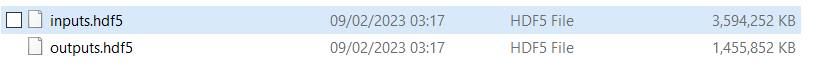

In [7]:
class HDF5DatasetGenerator:
    def __init__(self, dbPath, batchSize, preprocessors=None,
        aug=None, binarize=True, classes=2):
        # store the batch size, preprocessors, and data augmentor,
        # whether or not the labels should be binarized, along with
        # the total number of classes
        self.batchSize = batchSize
        self.preprocessors = preprocessors
        self.aug = aug
        self.binarize = binarize
        self.classes = classes

        # open the HDF5 database for reading and determine the total
        # number of entries in the database
        self.db = h5py.File(dbPath, "r")
        self.numImages = self.db["labels"].shape[0]

    def generator(self, passes=np.inf):
        # initialize the epoch count
        epochs = 0

        # keep looping infinitely -- the model will stop once we have
        # reach the desired number of epochs
        while epochs < passes:
            # loop over the HDF5 dataset
            for i in np.arange(0, self.numImages, self.batchSize):
                # extract the images and labels from the HDF dataset
                images = self.db["images"][i: i + self.batchSize]
                labels = self.db["labels"][i: i + self.batchSize]

                # check to see if the labels should be binarized
                if self.binarize:
                    labels = to_categorical(labels,
                        self.classes)

                # check to see if our preprocessors are not None
                if self.preprocessors is not None:
                    # initialize the list of processed images
                    procImages = []

                    # loop over the images
                    for image in images:
                        # loop over the preprocessors and apply each
                        # to the image
                        for p in self.preprocessors:
                            image = p.preprocess(image)

                        # update the list of processed images
                        procImages.append(image)

                    # update the images array to be the processed
                    # images
                    images = np.array(procImages)

                # if the data augmenator exists, apply it
                if self.aug is not None:
                    (images, labels) = next(self.aug.flow(images,
                        labels, batch_size=self.batchSize))

                # yield a tuple of images and labels
                yield (images, labels)

            # increment the total number of epochs
            epochs += 1

    def close(self):
        # close the database
        self.db.close()

In [8]:
class SRCNN:
    @staticmethod
    def build(width, height, depth):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # the entire SRCNN architecture consists of three CONV =>
        # RELU layers with *no* zero-padding
        model.add(Conv2D(64, (9, 9), kernel_initializer="he_normal",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(Conv2D(32, (1, 1), kernel_initializer="he_normal"))
        model.add(Activation("relu"))
        model.add(Conv2D(depth, (5, 5),
            kernel_initializer="he_normal"))
        model.add(Activation("relu"))

        # return the constructed network architecture
        return model

In [9]:
def super_res_generator(inputDataGen, targetDataGen):
    # start an infinite loop for the training data
    while True:
        # grab the next input images and target outputs, discarding
        # the class labels (which are irrelevant)
        inputData = next(inputDataGen)[0]
        targetData = next(targetDataGen)[0]

        # yield a tuple of the input data and target data
        yield (inputData, targetData)

In [10]:
# initialize the input images and target output images generators
inputs = HDF5DatasetGenerator(config.INPUTS_DB, config.BATCH_SIZE)
targets = HDF5DatasetGenerator(config.OUTPUTS_DB, config.BATCH_SIZE)

# initialize the model and optimizer
print("[INFO] compiling model...")
opt = Adam(learning_rate=0.001, decay=0.001 / config.NUM_EPOCHS)
model = SRCNN.build(width=config.INPUT_DIM, height=config.INPUT_DIM,
    depth=3)
model.compile(loss="mse", optimizer=opt)

# train the model using our generators
H = model.fit(
    super_res_generator(inputs.generator(), targets.generator()),
    steps_per_epoch=inputs.numImages // config.BATCH_SIZE,
    epochs=config.NUM_EPOCHS, verbose=1)

[INFO] compiling model...
Epoch 1/10
1100/1100 [==============================] - 16s 7ms/step - loss: 260.9317
Epoch 2/10
1100/1100 [==============================] - 8s 7ms/step - loss: 66.8203
Epoch 3/10
1100/1100 [==============================] - 8s 7ms/step - loss: 62.1591
Epoch 4/10
1100/1100 [==============================] - 8s 7ms/step - loss: 54.3719
Epoch 5/10
1100/1100 [==============================] - 8s 7ms/step - loss: 53.5966
Epoch 6/10
1100/1100 [==============================] - 8s 7ms/step - loss: 67.1267
Epoch 7/10
1100/1100 [==============================] - 8s 7ms/step - loss: 50.1054
Epoch 8/10
1100/1100 [==============================] - 8s 7ms/step - loss: 48.2541
Epoch 9/10
1100/1100 [==============================] - 8s 8ms/step - loss: 51.1476
Epoch 10/10
1100/1100 [==============================] - 8s 8ms/step - loss: 43.8131


[INFO] serializing model...
INFO:tensorflow:Assets written to: output\srcnn.model\assets


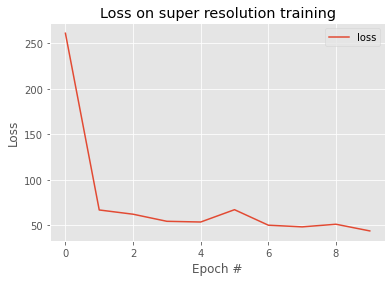

In [11]:
# save the model to file
print("[INFO] serializing model...")
model.save(config.MODEL_PATH, overwrite=True)

# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, config.NUM_EPOCHS), H.history["loss"],label="loss")
plt.title("Loss on super resolution training")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig(config.PLOT_PATH)

# close the HDF5 datasets
inputs.close()
targets.close()

[INFO] loading model...
[INFO] generating image...
(333, 250, 3)


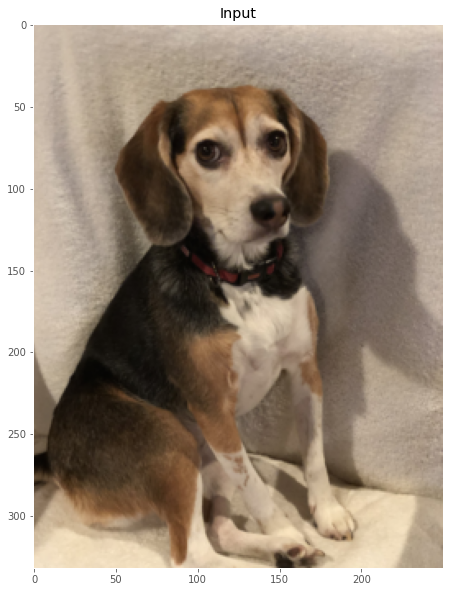

In [14]:
# load the pre-trained model
print("[INFO] loading model...")
model = load_model(config.MODEL_PATH)

# load the input image, then grab the dimensions of the input image
# and crop the image such that it tiles nicely
print("[INFO] generating image...")
image = cv2.imread('jemma.png')
print(image.shape)
(h, w) = image.shape[:2]
w -= int(w % config.SCALE)
h -= int(h % config.SCALE)
image = image[0:h, 0:w]

# plot the image
plt_imshow("Input", image)

In [15]:
image.shape

(332, 250, 3)

C:\Users\Zeki\AppData\Local\Temp\ipykernel_21360\2504246017.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  scaled = np.array(Image.fromarray(image).resize((lowW, lowH),resample=PIL.Image.BICUBIC))
C:\Users\Zeki\AppData\Local\Temp\ipykernel_21360\2504246017.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  scaled = np.array(Image.fromarray(scaled).resize((highW, highH),resample=PIL.Image.BICUBIC))


(166, 125, 3)


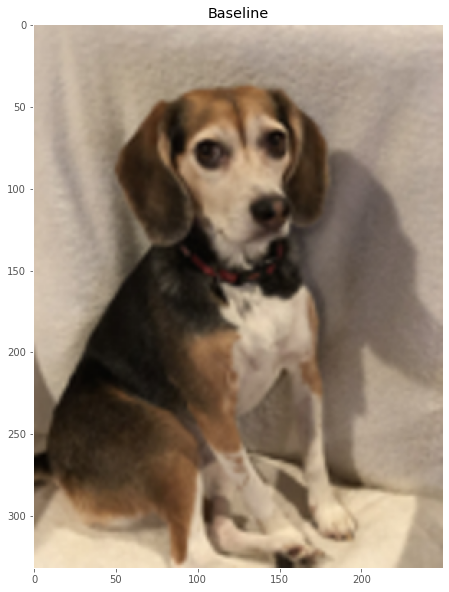

In [17]:
# resize the input image using bicubic interpolation then write the
# baseline image to disk
lowW = int(w * (1.0 / config.SCALE))
lowH = int(h * (1.0 / config.SCALE))
highW = int(lowW * (config.SCALE / 1.0))
highH = int(lowH * (config.SCALE / 1.0))
scaled = np.array(Image.fromarray(image).resize((lowW, lowH),resample=PIL.Image.BICUBIC))
print(scaled.shape)
scaled = np.array(Image.fromarray(scaled).resize((highW, highH),resample=PIL.Image.BICUBIC))
cv2.imwrite('bicubic_2.png', scaled)

# plot the baseline image
plt_imshow("Baseline", scaled)

In [18]:
scaled.shape

(332, 250, 3)

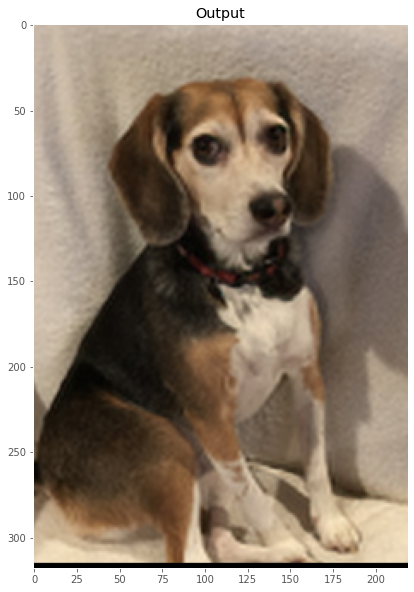

In [20]:
# allocate memory for the output image
output = np.zeros(scaled.shape)
(h, w) = output.shape[:2]

# slide a window from left-to-right and top-to-bottom
for y in range(0, h - config.INPUT_DIM + 1, config.LABEL_SIZE):
    for x in range(0, w - config.INPUT_DIM + 1, config.LABEL_SIZE):
        # crop ROI from our scaled image
        crop = scaled[y:y + config.INPUT_DIM,
            x:x + config.INPUT_DIM].astype("float32")

        # make a prediction on the crop and store it in our output
        # image
        P = model.predict(np.expand_dims(crop, axis=0))
        P = P.reshape((config.LABEL_SIZE, config.LABEL_SIZE, 3))
        output[y + config.PAD:y + config.PAD + config.LABEL_SIZE,
            x + config.PAD:x + config.PAD + config.LABEL_SIZE] = P

# remove any of the black borders in the output image caused by the
# padding, then clip any values that fall outside the range [0, 255]
output = output[config.PAD:h - ((h % config.INPUT_DIM) + config.PAD),
    config.PAD:w - ((w % config.INPUT_DIM) + config.PAD)]
output = np.clip(output, 0, 255).astype("uint8")

# write the output image to disk
cv2.imwrite('srcnn_2.png', output)

# plot the output of the model
plt_imshow("Output", output)

To see the results clearly , I took a screenshot of both images. 
 
 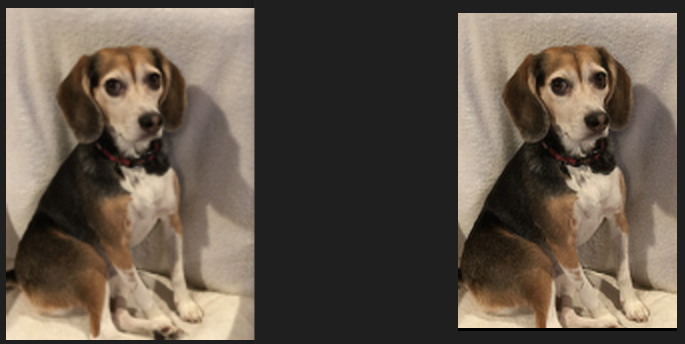


As you can from here, rigthside is SRCNN and it is a more detailed image